**Section 1: Cleaning the data**

In order to calculate the win probability of games live, we first must obtain play-by-play data for games over the past few seasons. Thankfully, this can be obtained from kaggle: https://www.kaggle.com/schmadam97/nba-playbyplay-data-20182019. This data was obtained by scraping Basketball Reference. 

In order to clean this data, we must do two things:

1. Clean the data so that only the relevant stats are kept (quarter, time left in quarter, home score, away score, winning team)
2. Add pre-game home and away ELO to the appropriate games

To view the ELO calculation look at the model formulation for the prediction of the overall winner pre-game

In [119]:
# Handle imports
import os, glob
import pandas as pd
import datetime
import pytz
from tqdm.notebook import tqdm, trange
import time

# For models
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier

import pickle

In [ ]:
# Combine season csv's into 1 CSV
all_files = glob.glob(os.path.join('./archive', "*.csv"))
df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
df_merged = pd.concat(df_from_each_file, ignore_index=True)
df_merged.to_csv( "all_seasons_pbp.csv")

In [7]:
# Load independent CSV's to dataframes
elo_df = pd.read_csv('elo_by_game.csv')
pbp_df = pd.read_csv('all_seasons_pbp.csv')

In [ ]:
print(len(pbp_df))

In [9]:
pbp_df = pbp_df.loc[:, ~pbp_df.columns.str.contains('^Unnamed')]
pbp_df = pbp_df[['Date', 'WinningTeam', 'Quarter', 'SecLeft', 'AwayTeam', 'HomeTeam', 'AwayScore', 'HomeScore', 'Time']]

pbp_df.head()

,Date,WinningTeam,Quarter,SecLeft,AwayTeam,HomeTeam,AwayScore,HomeScore,Time
0,October 17 2017,CLE,1,720,BOS,CLE,0,0,8:01 PM
1,October 17 2017,CLE,1,704,BOS,CLE,2,0,8:01 PM
2,October 17 2017,CLE,1,687,BOS,CLE,2,0,8:01 PM
3,October 17 2017,CLE,1,683,BOS,CLE,2,0,8:01 PM
4,October 17 2017,CLE,1,681,BOS,CLE,2,0,8:01 PM


In [10]:
# Make team names consistent
abv_to_name_dict = {
    "ATL": "Atlanta Hawks",
    "BOS": "Boston Celtics",
    "BRK": "Brooklyn Nets",
    "CHO": "Charlotte Hornets",
    "CHI": "Chicago Bulls",
    "CLE": "Cleveland Cavaliers",
    "DAL": "Dallas Mavericks",
    "DEN": "Denver Nuggets",
    "DET": "Detroit Pistons",
    "GSW": "Golden State Warriors",
    "HOU": "Houston Rockets",
    "IND": "Indiana Pacers",
    "LAC": "LA Clippers",
    "LAL": "Los Angeles Lakers",
    "MEM": "Memphis Grizzlies",
    "MIA": "Miami Heat",
    "MIL": "Milwaukee Bucks",
    "MIN": "Minnesota Timberwolves",
    "NOP": "New Orleans Pelicans",
    "NYK": "New York Knicks",
    "OKC": "Oklahoma City Thunder",
    "ORL": "Orlando Magic",
    "PHI": "Philadelphia 76ers",
    "PHO": "Phoenix Suns",
    "POR": "Portland Trail Blazers",
    "SAC": "Sacramento Kings",
    "SAS": "San Antonio Spurs",
    "TOR": "Toronto Raptors",
    "UTA": "Utah Jazz",
    "WAS": "Washington Wizards"
}

pbp_df = pbp_df.replace({"WinningTeam": abv_to_name_dict})
pbp_df = pbp_df.replace({"AwayTeam": abv_to_name_dict})
pbp_df = pbp_df.replace({"HomeTeam": abv_to_name_dict})

pbp_df['HomeScore'] = pbp_df['HomeScore'].astype(int)
pbp_df['AwayScore'] = pbp_df['AwayScore'].astype(int)
pbp_df["DateAndTime"] = pbp_df['Date'] + " " + pbp_df['Time']
pbp_df["Datetime"] = pd.to_datetime(pbp_df["DateAndTime"])

# pbp_df['Date']= pd.to_datetime(pbp_df['Date'])

pbp_df.head()

,Date,WinningTeam,Quarter,SecLeft,AwayTeam,HomeTeam,AwayScore,HomeScore,Time,DateAndTime,Datetime
0,October 17 2017,Cleveland Cavaliers,1,720,Boston Celtics,Cleveland Cavaliers,0,0,8:01 PM,October 17 2017 8:01 PM,2017-10-17 20:01:00
1,October 17 2017,Cleveland Cavaliers,1,704,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-17 20:01:00
2,October 17 2017,Cleveland Cavaliers,1,687,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-17 20:01:00
3,October 17 2017,Cleveland Cavaliers,1,683,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-17 20:01:00
4,October 17 2017,Cleveland Cavaliers,1,681,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-17 20:01:00


In [11]:
pbp_df["Datetime"] = pbp_df["Datetime"].dt.tz_localize('US/Eastern')
pbp_df["Datetime"] = pbp_df["Datetime"].dt.tz_convert('UTC')

pbp_df.head()

,Date,WinningTeam,Quarter,SecLeft,AwayTeam,HomeTeam,AwayScore,HomeScore,Time,DateAndTime,Datetime
0,October 17 2017,Cleveland Cavaliers,1,720,Boston Celtics,Cleveland Cavaliers,0,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18 00:01:00+00:00
1,October 17 2017,Cleveland Cavaliers,1,704,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18 00:01:00+00:00
2,October 17 2017,Cleveland Cavaliers,1,687,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18 00:01:00+00:00
3,October 17 2017,Cleveland Cavaliers,1,683,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18 00:01:00+00:00
4,October 17 2017,Cleveland Cavaliers,1,681,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18 00:01:00+00:00


In [12]:
# Drop time for consistency
pbp_df['Datetime'] = pbp_df['Datetime'].dt.date

pbp_df.head()

,Date,WinningTeam,Quarter,SecLeft,AwayTeam,HomeTeam,AwayScore,HomeScore,Time,DateAndTime,Datetime
0,October 17 2017,Cleveland Cavaliers,1,720,Boston Celtics,Cleveland Cavaliers,0,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18
1,October 17 2017,Cleveland Cavaliers,1,704,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18
2,October 17 2017,Cleveland Cavaliers,1,687,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18
3,October 17 2017,Cleveland Cavaliers,1,683,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18
4,October 17 2017,Cleveland Cavaliers,1,681,Boston Celtics,Cleveland Cavaliers,2,0,8:01 PM,October 17 2017 8:01 PM,2017-10-18


In [ ]:
data_builder = {
    "h_elo": [],
    "a_elo": [],
    "a_team": [],
    "h_team": [],
    "h_score": [],
    "a_score": [],
    "winning_team": [],
    "quarter": [],
    "seconds_in_quarter": []
}

# Add home and away elo's to dataframe

last_datetime = ""
last_h_team = ""
last_a_team = ""
last_h_elo = -1.0
last_a_elo = -1.0

p_bar = tqdm(total=len(pbp_df))
for index, row in pbp_df.iterrows():

    curr_datetime = str(row['Datetime'])
    curr_h_team = row["HomeTeam"]
    curr_a_team = row["AwayTeam"]

    if curr_a_team == last_a_team and curr_h_team == last_h_team and curr_datetime == last_datetime:
        data_builder["h_elo"].append(last_h_elo)
        data_builder["a_elo"].append(last_a_elo)
    else:
        filtered_df = elo_df.loc[(elo_df['date'] == curr_datetime)]
        filtered_df = filtered_df.loc[filtered_df['home_team'] == curr_h_team]
        filtered_df = filtered_df.loc[filtered_df['away_team'] == curr_a_team]

        if len(filtered_df) == 0:
            continue

        curr_h_elo = filtered_df["h_elo_before"].values[0]
        curr_a_elo = filtered_df["a_elo_before"].values[0]

        last_datetime = curr_datetime
        last_h_team = curr_h_team
        last_a_team = curr_a_team
        last_h_elo = curr_h_elo
        last_a_elo = curr_a_elo

        data_builder["h_elo"].append(last_h_elo)
        data_builder["a_elo"].append(last_a_elo)

    data_builder["h_team"].append(last_h_team)
    data_builder["a_team"].append(last_a_team)
    data_builder["h_score"].append(row["HomeScore"])
    data_builder["a_score"].append(row["AwayScore"])
    data_builder["winning_team"].append(row["WinningTeam"])
    data_builder["quarter"].append(row["Quarter"])
    data_builder["seconds_in_quarter"].append(row["SecLeft"])

    p_bar.update(1)

final_pbp_df = pd.DataFrame(data_builder)

final_pbp_df.head()

In [ ]:
final_pbp_df.to_csv( "final_pbp_data.csv")

In [3]:
final_pbp_df = pd.read_csv('final_pbp_data.csv')

In [4]:
# Create column for winner label (home team wins)
final_pbp_df['true_winner'] = [1 if x > 0 else 0 for x in final_pbp_df['h_score'] - final_pbp_df['a_score']]
final_pbp_df = final_pbp_df.loc[:, ~final_pbp_df.columns.str.contains('^Unnamed')]
final_pbp_df = final_pbp_df[['h_elo', 'a_elo', 'h_score', 'a_score', 'quarter', 'seconds_in_quarter', 'true_winner']]
final_pbp_df['seconds_in_quarter'] = final_pbp_df['seconds_in_quarter'].astype(int)
final_pbp_df['quarter'] = final_pbp_df['quarter'].astype(int)

final_pbp_df.head()

,h_elo,a_elo,h_score,a_score,quarter,seconds_in_quarter,true_winner
0,1636.166122,1530.594813,0,0,1,720,0
1,1636.166122,1530.594813,0,2,1,704,0
2,1636.166122,1530.594813,0,2,1,687,0
3,1636.166122,1530.594813,0,2,1,683,0
4,1636.166122,1530.594813,0,2,1,681,0


**Section 2: Creating the model**

After much research, it seems like the most commonly used model to solve this problem was a logistic regression model. This, naturally, was what I tried first. After consulting with the developer of https://www.inpredictable.com/, he mentioned that a seemingly better alternative was to use XGBoost, which did largely the same thing, with slightly better accuracy and low tuning.

In [5]:
# Split data into X and Y sets for fitting to the model

y = final_pbp_df['true_winner']
final_pbp_df.drop(columns=['true_winner'], inplace=True)
X = final_pbp_df

X.head()

,h_elo,a_elo,h_score,a_score,quarter,seconds_in_quarter
0,1636.166122,1530.594813,0,0,1,720
1,1636.166122,1530.594813,0,2,1,704
2,1636.166122,1530.594813,0,2,1,687
3,1636.166122,1530.594813,0,2,1,683
4,1636.166122,1530.594813,0,2,1,681


In [ ]:
# Using XGBoost

# md1<-locfit(won ~ lp(line,gt,m, style=c("cpar","n"),scale=T, nn=0.25), family="binomial", data= wda, weights=cnt, maxk=1000)
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
xg_reg = xgb.XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [ ]:
# Error calc
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

In [ ]:
print((cv_results["test-rmse-mean"]).tail(1))
print(params)

In [ ]:
# sample_df = elo_df.loc[(elo_df['date'] == '2018-12-23')]
# sample_df = sample_df.loc[sample_df['home_team'] == 'Washington Wizards']
# sample_df = sample_df.loc[sample_df['away_team'] == 'Phoenix Suns']

# h_elo = 1438.7638
# a_elo = 1344.235583

# sample_df.head()

In [13]:
new_data_builder = {
    "h_elo": [],
    "a_elo": [],
    "a_team": [],
    "h_team": [],
    "h_score": [],
    "a_score": [],
    "winning_team": [],
    "quarter": [],
    "seconds_in_quarter": []
}

p_bar = tqdm(total=len(pbp_df))
for index, row in pbp_df.iterrows():
    if str(row['Datetime']) == '2018-12-23' and row['HomeTeam'] == 'Washington Wizards' and row['AwayTeam'] == 'Phoenix Suns':
        new_data_builder["h_elo"].append(1438.7638)
        new_data_builder["a_elo"].append(1344.235583)
        new_data_builder["h_team"].append(row['HomeTeam'])
        new_data_builder["a_team"].append(row['AwayTeam'])
        new_data_builder["h_score"].append(row["HomeScore"])
        new_data_builder["a_score"].append(row["AwayScore"])
        new_data_builder["winning_team"].append(row["WinningTeam"])
        new_data_builder["quarter"].append(row["Quarter"])
        new_data_builder["seconds_in_quarter"].append(row["SecLeft"])

    p_bar.update(1)

sample_game = pd.DataFrame(new_data_builder)

In [ ]:
sample_game.to_csv("sample_game.csv")

In [ ]:
sample_game = pd.read_csv('sample_game.csv')

In [ ]:
sample_game = sample_game.sort_values(["quarter", "seconds_in_quarter"], ascending=(True, False))
sample_game.head()

In [ ]:
sample_game = sample_game[['h_elo', 'a_elo', 'h_score', 'a_score', 'quarter', 'seconds_in_quarter']]
sample_game.head()

In [ ]:
probabilities = xg_reg.predict_proba(sample_game)

probabilities

In [21]:
x_axis = []
for index, row in sample_game.iterrows():

    to_append = 0

    curr_quarter = row["quarter"]
    curr_seconds = row["seconds_in_quarter"]

    if curr_quarter > 4:
        to_append += 720 * 4
        to_append += (curr_quarter - 5) * 300
        to_append += 300 - curr_seconds
    else:
        to_append += (curr_quarter - 1) * 720
        to_append += 720 - curr_seconds

    if len(x_axis) != 0 and to_append <= x_axis[len(x_axis) - 1]:
        to_append = x_axis[len(x_axis) - 1] + 0.2
    x_axis.append(to_append)


In [ ]:
plot_arr = []
for i in probabilities:
    plot_arr.append(i)
plt.plot(plot_arr)
plt.ylabel('some numbers')
plt.show()

*Logistic Regression*

In [ ]:
clf = LogisticRegression(random_state=0).fit(X, y)
temp = clf.predict_proba(sample_game)

In [ ]:
logistic = LogisticRegression(random_state=23)
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

logreg_cv = GridSearchCV(logistic, param_grid, cv=5)
logreg_cv.fit(X, y)

print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

In [ ]:
temp2 = logreg_cv.predict_proba(sample_game)
temp2 = [x[1] for x in temp2]

In [ ]:
plt.plot(x_axis, temp2)
plt.ylabel('some numbers')
plt.show()

In [ ]:
predictions = logreg_cv.predict(sample_game)
predictions

Try using feature: "score differential"

In [15]:
# Make point differential column
X_without_score = X[['h_elo', 'a_elo', 'quarter', 'seconds_in_quarter']]
X_without_score["point_diff"] = X["h_score"] - X["a_score"]

X_without_score.head()

/Users/adityanaik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,h_elo,a_elo,quarter,seconds_in_quarter,point_diff
0,1636.166122,1530.594813,1,720,0
1,1636.166122,1530.594813,1,704,-2
2,1636.166122,1530.594813,1,687,-2
3,1636.166122,1530.594813,1,683,-2
4,1636.166122,1530.594813,1,681,-2


In [56]:
game_without_score = sample_game[['h_elo', 'a_elo', 'quarter', 'seconds_in_quarter']]
game_without_score["point_diff"] = sample_game["h_score"] - sample_game["a_score"]

game_without_score.head()

/Users/adityanaik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,h_elo,a_elo,quarter,seconds_in_quarter,point_diff
0,1438.7638,1344.235583,1,720,0
1,1438.7638,1344.235583,1,701,0
2,1438.7638,1344.235583,1,700,0
3,1438.7638,1344.235583,1,691,2
4,1438.7638,1344.235583,1,669,-1


In [17]:
clf_w_diff = LogisticRegression(random_state=23)

c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

clf_w_diff_cv = GridSearchCV(clf_w_diff, param_grid, cv=5)
clf_w_diff_cv.fit(X_without_score, y)

print("Tuned Logistic Regression Parameters: {}".format(clf_w_diff_cv.best_params_))
print("Best score is {}".format(clf_w_diff_cv.best_score_))

/Users/adityanaik/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/adityanaik/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

In [18]:
no_score_prob = clf_w_diff_cv.predict_proba(game_without_score)
no_score_prob = [x[1] for x in no_score_prob]

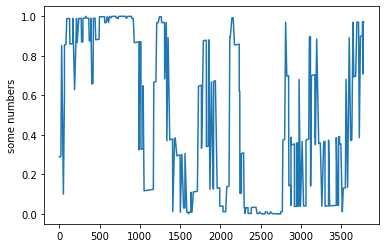

In [22]:
plt.plot(x_axis, no_score_prob)
plt.ylabel('some numbers')
plt.show()

Lowess

In [30]:
lowess_sm = sm.nonparametric.lowess
yest_sm = lowess_sm(no_score_prob,x_axis,frac=1./30.,it=3, return_sorted = False)

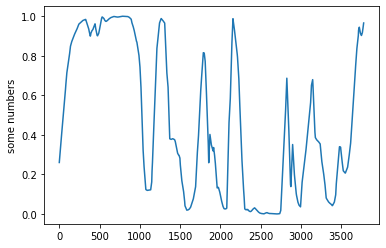

In [31]:
plt.plot(x_axis, yest_sm)
plt.ylabel('some numbers')
plt.show()

Try using total time left

In [50]:
# Make point differential column
X_tot_time = X_without_score[['h_elo', 'a_elo', 'point_diff']]
X_tot_time.head()

,h_elo,a_elo,point_diff
0,1636.166122,1530.594813,0
1,1636.166122,1530.594813,-2
2,1636.166122,1530.594813,-2
3,1636.166122,1530.594813,-2
4,1636.166122,1530.594813,-2


In [68]:
time_col = []
for index, row in X_without_score.iterrows():

    to_append = 720 * 4

    curr_quarter = row["quarter"]
    curr_seconds = row["seconds_in_quarter"]

    if curr_quarter <= 4:
        to_append -= 720 * (int(curr_quarter) - 1)
        to_append -= 720 - curr_seconds
    else:
        to_append = curr_seconds

    time_col.append(to_append)

    last_ind = len(time_col) - 1
    while last_ind > 0 and time_col[last_ind - 1] <= time_col[last_ind]:
        time_col[last_ind - 1] += 0.1
        counter += 1
        last_ind -= 1

3034901


In [69]:
X_tot_time['time_left'] = time_col
X_tot_time.head()

/Users/adityanaik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,h_elo,a_elo,point_diff,time_left
0,1636.166122,1530.594813,0,2880.0
1,1636.166122,1530.594813,-2,2864.0
2,1636.166122,1530.594813,-2,2847.0
3,1636.166122,1530.594813,-2,2843.0
4,1636.166122,1530.594813,-2,2841.0


In [70]:
game_tot_time = game_without_score[['h_elo', 'a_elo', 'point_diff']]
game_tot_time.head()

,h_elo,a_elo,point_diff
0,1438.7638,1344.235583,0
1,1438.7638,1344.235583,0
2,1438.7638,1344.235583,0
3,1438.7638,1344.235583,2
4,1438.7638,1344.235583,-1


In [71]:
time_col_game = []
for index, row in game_without_score.iterrows():

    to_append = 720 * 4

    curr_quarter = row["quarter"]
    curr_seconds = row["seconds_in_quarter"]

    if curr_quarter <= 4:
        to_append -= 720 * (int(curr_quarter) - 1)
        to_append -= 720 - curr_seconds
    else:
        to_append = curr_seconds

    # if (to_append < 0):
    #     print(to_append)
    #     print("Q: " + str(curr_quarter))
    #     print("S: " + str(curr_seconds))

    time_col_game.append(to_append)

    last_ind = len(time_col_game) - 1
    while last_ind > 0 and time_col_game[last_ind - 1] <= time_col_game[last_ind]:
        time_col_game[last_ind - 1] += 0.1
        counter += 1
        last_ind -= 1

In [74]:
game_tot_time['time_left'] = pd.Series(time_col_game)
game_tot_time.head()

/Users/adityanaik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,h_elo,a_elo,point_diff,time_left
0,1438.7638,1344.235583,0,2880.0
1,1438.7638,1344.235583,0,2861.0
2,1438.7638,1344.235583,0,2860.0
3,1438.7638,1344.235583,2,2851.0
4,1438.7638,1344.235583,-1,2829.0


In [77]:
clf_tot_time = LogisticRegression(random_state=23)

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

param_grid = dict(solver=solvers,penalty=penalty,C=c_values)

clf_tot_time_cv = GridSearchCV(clf_tot_time, param_grid, cv=5)
clf_tot_time_cv.fit(X_tot_time, y)

print("Tuned Logistic Regression Parameters: {}".format(clf_tot_time_cv.best_params_))
print("Best score is {}".format(clf_tot_time_cv.best_score_))

/Users/adityanaik/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/adityanaik/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/adityanaik/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/adityanaik/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/adityanaik/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarn

In [78]:
tot_time_prob = clf_tot_time_cv.predict_proba(game_tot_time)
tot_time_prob = [x[1] for x in tot_time_prob]

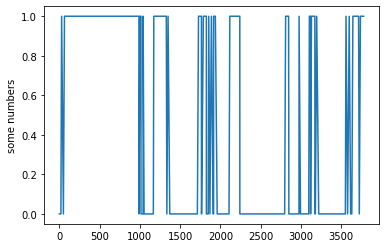

In [79]:
plt.plot(x_axis, tot_time_prob)
plt.ylabel('some numbers')
plt.show()

KNN

In [110]:
knn_model = KNeighborsClassifier(n_neighbors=70, p=1, leaf_size=50)
knn_model.fit(X_tot_time, y)

KNeighborsClassifier(algorithm='auto', leaf_size=50, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=70, p=1,
                     weights='uniform')

In [111]:
probs_knn = knn_model.predict_proba(game_tot_time)
probs_knn = [x[1] for x in probs_knn]

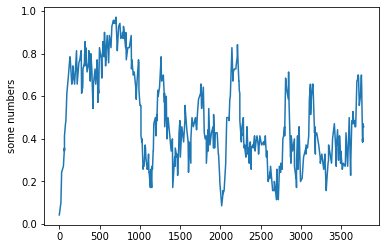

In [112]:
plt.plot(x_axis, probs_knn)
plt.ylabel('some numbers')
plt.show()

In [102]:
# Tuning
# List Hyperparameters that we want to tune.
leaf_size = [5, 30]
n_neighbors = [10, 30, 50, 70]
p=[1,2]

# Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

# Create new KNN object
knn_2 = KNeighborsClassifier()

# Use GridSearch
knn_2_tuned = GridSearchCV(knn_2, hyperparameters, cv=10, verbose=2)

# Fit the model
best_model_knn = knn_2_tuned.fit(X_tot_time,y)

# Print The value of best Hyperparameters
print('Best leaf_size:', best_model_knn.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model_knn.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model_knn.best_estimator_.get_params()['n_neighbors'])

[CV] leaf_size=5, n_neighbors=30, p=1 ................................
[CV] ................. leaf_size=5, n_neighbors=30, p=1, total=  20.4s
[CV] leaf_size=5, n_neighbors=30, p=1 ................................
[CV] ................. leaf_size=5, n_neighbors=30, p=1, total=  19.8s
[CV] leaf_size=5, n_neighbors=30, p=1 ................................
[CV] ................. leaf_size=5, n_neighbors=30, p=1, total=  19.8s
[CV] leaf_size=5, n_neighbors=30, p=1 ................................
[CV] ................. leaf_size=5, n_neighbors=30, p=1, total=  20.0s
[CV] leaf_size=5, n_neighbors=30, p=1 ................................
[CV] ................. leaf_size=5, n_neighbors=30, p=1, total=  19.9s
[CV] leaf_size=5, n_neighbors=30, p=1 ................................
[CV] ................. leaf_size=5, n_neighbors=30, p=1, total=  19.7s
[CV] leaf_size=5, n_neighbors=30, p=1 ................................
[CV] ................. leaf_size=5, n_neighbors=30, p=1, total=  20.1s
[CV] l

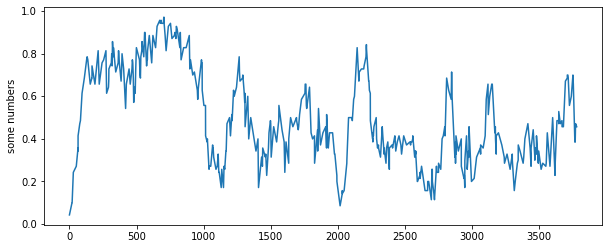

In [117]:
probs_knn_2 = best_model_knn.predict_proba(game_tot_time)
probs_knn_2 = [x[1] for x in probs_knn_2]

plt.figure(figsize=(10,4))
plt.plot(x_axis, probs_knn_2)
plt.ylabel('some numbers')
plt.show()

Finally, I decided to use a KNN, as it gave me predictions approximating that of typically used tools. There are some areas that can be improved upon however. Mostly, this includes smoothing out the curve so that the likelihood swings less drastically. Additionally, the model tends to perform not as well near the end of games, as possession is not being tracked (which ideally it should be). This is simply due to a lack of data.

In [120]:
# Store tuned KNN model
pickle.dump(best_model_knn, open('../../mustafar/live_prediction_model.pkl', 'wb'))